<a href="https://colab.research.google.com/github/wksmirnowa/machinelearning_homeworks/blob/master/HW07_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Сверточные нейронные сети

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install pandas scikit-learn matplotlib

In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from string import punctuation, digits, ascii_lowercase
punct = punctuation+'«»—…“”*№–'

In [0]:
def model_picture(model):
  print(model.history.history.keys())
  plt.plot(model.history.history['f1'])
  plt.plot(model.history.history['val_f1'])
  plt.title('model f1')
  plt.ylabel('f1')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [0]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
quora = pd.read_csv('/content/drive/My Drive/quora.csv')

## Посимвольная токенизация с сохранением всех символов

In [0]:
def sym_tokenize(text):
  text = text.lower()
  spaces = '\t\n\r\x0b\x0c' #из символов модуля string
  result = []

  for sym in text:
    if sym in spaces or sym == ' ':
      result.append(' ')
    else:
      result.append(sym)
  return result


In [0]:
# словарь

def make_vocab(texts):
  vocab = Counter()

  for text in texts:
      vocab.update(sym_tokenize(text))

  filtered_vocab = set()

  for sym in vocab:
    if vocab[sym] > 1:
        filtered_vocab.add(sym)
        
  return filtered_vocab

In [0]:
quora_vocab = make_vocab(quora.question_text)

In [0]:
len(quora_vocab)

77

In [0]:
sym2id = {'UNK':1, 'PAD':0}
for sym in quora_vocab:
    sym2id[sym] = len(sym2id)

In [0]:
id2sym = {i:sym for sym, i in sym2id.items()}

In [0]:
# переводим тексты в последовательности индексов
X = []

for text in quora.question_text:
    tokens = sym_tokenize(text)
    ids = [sym2id.get(token, 1) for token in tokens]
    X.append(ids)

In [0]:
MAX_LEN = max(len(x) for x in X)

In [0]:
MAX_LEN

1017

In [0]:
MEAN_LEN = np.median([len(x) for x in X])

In [0]:
MAX_LEN = int(MEAN_LEN + 5)

In [0]:
MAX_LEN

65

In [0]:
# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [0]:
X.shape

(1306122, 65)

In [0]:
y = quora.target.values

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y, random_state=42)

### 1 попытка собрать все слои

In [0]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.weights', 
                                                monitor='val_f1', 
                                                verbose=1, 
                                                save_weights_only=True, 
                                                save_best_only=True, 
                                                mode='max', 
                                                save_freq='epoch' 
                                               )

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_f1', 
                                              min_delta=0.01, 
                                              patience=5, 
                                              verbose=1, 
                                              mode='max',
                                              )


In [0]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(sym2id), output_dim=50)(inputs, )

convs = []

conv1 = tf.keras.layers.Conv1D(kernel_size=5, filters=8, strides=1, activation='relu')(embeddings)
conv2 = tf.keras.layers.Conv1D(kernel_size=5, filters=8, strides=1, activation='relu')(conv1)
conv3 = tf.keras.layers.Conv1D(kernel_size=5, filters=8, strides=1, activation='relu')(conv2)
pool1 = tf.keras.layers.AveragePooling1D()(conv3)
drop1 = tf.keras.layers.Dropout(0.2)(pool1)
convs.append(drop1)

conv4 = tf.keras.layers.Conv1D(kernel_size=5, filters=16, strides=1, activation='relu')(embeddings)
conv5 = tf.keras.layers.Conv1D(kernel_size=5, filters=16, strides=1, activation='relu')(conv4)
conv6 = tf.keras.layers.Conv1D(kernel_size=5, filters=16, strides=1, activation='relu')(conv5)
pool2 = tf.keras.layers.AveragePooling1D()(conv6)
drop2 = tf.keras.layers.Dropout(0.2)(pool2)
convs.append(drop2)

conv7 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, activation='relu')(embeddings)
conv8 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, activation='relu')(conv7)
conv9 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, activation='relu')(conv8)
pool3 = tf.keras.layers.AveragePooling1D()(conv9)
drop3 = tf.keras.layers.Dropout(0.2)(pool3)
convs.append(drop3)

concat = tf.keras.layers.Concatenate()(convs)
dense1 = tf.keras.layers.Dense(64, activation='relu')(concat)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense1)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])


In [0]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 65)]         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 65, 50)       52900       input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_45 (Conv1D)              (None, 61, 8)        2008        embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_48 (Conv1D)              (None, 61, 16)       4016        embedding_5[0][0]                
____________________________________________________________________________________________

In [0]:
%%time
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=500,
         epochs=10,
        callbacks=[checkpoint, early_stop])

Epoch 1/10
2480/2482 [============================>.] - ETA: 0s - loss: 0.2187 - f1: 0.1617
Epoch 00001: val_f1 improved from -inf to 0.61276, saving model to model.weights
2482/2482 [==============================] - 41s 17ms/step - loss: 0.2186 - f1: 0.1621 - val_loss: 0.2068 - val_f1: 0.6128
Epoch 2/10
2481/2482 [============================>.] - ETA: 0s - loss: 0.2053 - f1: 0.6607
Epoch 00002: val_f1 improved from 0.61276 to 0.72278, saving model to model.weights
2482/2482 [==============================] - 40s 16ms/step - loss: 0.2053 - f1: 0.6609 - val_loss: 0.2044 - val_f1: 0.7228
Epoch 3/10
2481/2482 [============================>.] - ETA: 0s - loss: 0.2023 - f1: 0.7252
Epoch 00003: val_f1 did not improve from 0.72278
2482/2482 [==============================] - 40s 16ms/step - loss: 0.2023 - f1: 0.7252 - val_loss: 0.2013 - val_f1: 0.7170
Epoch 4/10
2482/2482 [==============================] - ETA: 0s - loss: 0.2009 - f1: 0.7518
Epoch 00004: val_f1 improved from 0.72278 to 0.75

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


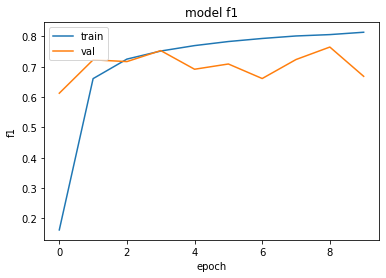

In [0]:
model_picture(model)

Валидация скачет, и обучение не сильно продвигается после второй эпохи.

### 2 попытка собрать все слои

In [0]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.weights',  
                                                monitor='val_f1', 
                                                verbose=1, 
                                                save_weights_only=True, 
                                                save_best_only=True, 
                                                mode='max', 
                                                save_freq='epoch' 
                                               )

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_f1', 
                                              min_delta=0.01,
                                              patience=5, 
                                              verbose=1, 
                                              mode='max',
                                              )

In [0]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(sym2id), output_dim=50)(inputs, )

convs = []

conv1 = tf.keras.layers.Conv1D(kernel_size=3, filters=32, strides=1, activation='relu')(embeddings)
conv2 = tf.keras.layers.Conv1D(kernel_size=3, filters=32, strides=1, activation='relu')(conv1)
conv3 = tf.keras.layers.Conv1D(kernel_size=3, filters=32, strides=1, activation='relu')(conv2)
pool1 = tf.keras.layers.AveragePooling1D()(conv3)
drop1 = tf.keras.layers.Dropout(0.2)(pool1)
convs.append(drop1)

conv4 = tf.keras.layers.Conv1D(kernel_size=3, filters=64, strides=1, activation='relu')(embeddings)
conv5 = tf.keras.layers.Conv1D(kernel_size=3, filters=64, strides=1, activation='relu')(conv4)
conv6 = tf.keras.layers.Conv1D(kernel_size=3, filters=64, strides=1, activation='relu')(conv5)
pool2 = tf.keras.layers.AveragePooling1D()(conv6)
drop2 = tf.keras.layers.Dropout(0.2)(pool2)
convs.append(drop2)

conv7 = tf.keras.layers.Conv1D(kernel_size=3, filters=16, strides=1, activation='relu')(embeddings)
conv8 = tf.keras.layers.Conv1D(kernel_size=3, filters=16, strides=1, activation='relu')(conv7)
conv9 = tf.keras.layers.Conv1D(kernel_size=3, filters=16, strides=1, activation='relu')(conv8)
pool3 = tf.keras.layers.AveragePooling1D()(conv9)
drop3 = tf.keras.layers.Dropout(0.2)(pool3)
convs.append(drop3)


concat = tf.keras.layers.Concatenate()(convs)
dense1 = tf.keras.layers.Dense(64, activation='relu')(concat)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense1)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])


In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 65)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 65, 50)       52900       input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 63, 32)       4832        embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 63, 64)       9664        embedding[0][0]                  
______________________________________________________________________________________________

In [0]:
%%time
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=10,
        callbacks=[checkpoint, early_stop])

Epoch 1/10
1241/1241 [==============================] - ETA: 0s - loss: 0.2281 - f1: 8.1559e-05
Epoch 00001: val_f1 improved from -inf to 0.00000, saving model to model.weights
1241/1241 [==============================] - 27s 21ms/step - loss: 0.2281 - f1: 8.1559e-05 - val_loss: 0.2164 - val_f1: 0.0000e+00
Epoch 2/10
1241/1241 [==============================] - ETA: 0s - loss: 0.2153 - f1: 0.2135
Epoch 00002: val_f1 improved from 0.00000 to 0.56082, saving model to model.weights
1241/1241 [==============================] - 26s 21ms/step - loss: 0.2153 - f1: 0.2135 - val_loss: 0.2124 - val_f1: 0.5608
Epoch 3/10
1240/1241 [============================>.] - ETA: 0s - loss: 0.2120 - f1: 0.4886
Epoch 00003: val_f1 improved from 0.56082 to 0.61214, saving model to model.weights
1241/1241 [==============================] - 26s 21ms/step - loss: 0.2120 - f1: 0.4886 - val_loss: 0.2107 - val_f1: 0.6121
Epoch 4/10
1239/1241 [============================>.] - ETA: 0s - loss: 0.2104 - f1: 0.5615
Ep

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


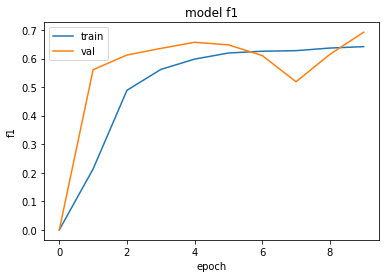

In [0]:
model_picture(model)

### 3 попытка собрать все слои

In [0]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.weights', 
                                                monitor='val_f1', 
                                                verbose=1, 
                                                save_weights_only=True, 
                                                save_best_only=True, 
                                                mode='max', 
                                                save_freq='epoch' 
                                               )

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_f1', 
                                              min_delta=0.01, 
                                              patience=5, 
                                              verbose=1, 
                                              mode='max',
                                              )

In [0]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(sym2id), output_dim=50)(inputs, )

convs = []

conv1 = tf.keras.layers.Conv1D(kernel_size=5, filters=16, strides=1, padding='same', activation='relu')(embeddings)
conv2 = tf.keras.layers.Conv1D(kernel_size=5, filters=16, strides=1, padding='same', activation='relu')(conv1)
conv3 = tf.keras.layers.Conv1D(kernel_size=5, filters=16, strides=1, padding='same', activation='relu')(conv2)
pool1 = tf.keras.layers.AveragePooling1D()(conv3)
drop1 = tf.keras.layers.Dropout(0.2)(pool1)
convs.append(drop1)

conv4 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, padding='same', activation='relu')(embeddings)
conv5 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, padding='same', activation='relu')(conv4)
conv6 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, padding='same', activation='relu')(conv5)
pool2 = tf.keras.layers.AveragePooling1D()(conv6)
drop2 = tf.keras.layers.Dropout(0.2)(pool2)
convs.append(drop2)

conv7 = tf.keras.layers.Conv1D(kernel_size=5, filters=16, strides=1, padding='same', activation='relu')(embeddings)
conv8 = tf.keras.layers.Conv1D(kernel_size=5, filters=16, strides=1, padding='same', activation='relu')(conv7)
conv9 = tf.keras.layers.Conv1D(kernel_size=5, filters=16, strides=1, padding='same', activation='relu')(conv8)
pool3 = tf.keras.layers.AveragePooling1D()(conv9)
drop3 = tf.keras.layers.Dropout(0.2)(pool3)
convs.append(drop3)


concat = tf.keras.layers.Concatenate()(convs)
dense1 = tf.keras.layers.Dense(64, activation='relu')(concat)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense1)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])


In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 65)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 65, 50)       3900        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 65, 16)       4016        embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 65, 32)       8032        embedding[0][0]                  
______________________________________________________________________________________________

In [0]:
%%time
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=10,
        callbacks=[checkpoint, early_stop])

Epoch 1/10
1241/1241 [==============================] - ETA: 0s - loss: 0.2259 - f1: 1.6090e-04
Epoch 00001: val_f1 improved from -inf to 0.00000, saving model to model.weights
1241/1241 [==============================] - 59s 47ms/step - loss: 0.2259 - f1: 1.6090e-04 - val_loss: 0.2108 - val_f1: 0.0000e+00
Epoch 2/10
1240/1241 [============================>.] - ETA: 0s - loss: 0.2089 - f1: 0.4042
Epoch 00002: val_f1 improved from 0.00000 to 0.69839, saving model to model.weights
1241/1241 [==============================] - 57s 46ms/step - loss: 0.2089 - f1: 0.4045 - val_loss: 0.2066 - val_f1: 0.6984
Epoch 3/10
1240/1241 [============================>.] - ETA: 0s - loss: 0.2053 - f1: 0.7151
Epoch 00003: val_f1 improved from 0.69839 to 0.80809, saving model to model.weights
1241/1241 [==============================] - 58s 47ms/step - loss: 0.2053 - f1: 0.7150 - val_loss: 0.2076 - val_f1: 0.8081
Epoch 4/10
1240/1241 [============================>.] - ETA: 0s - loss: 0.2033 - f1: 0.7705
Ep

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


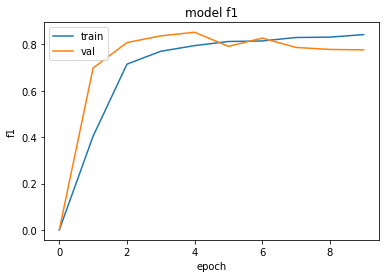

In [0]:
model_picture(model)

## Посимвольная токенизация с заменой особых символов на особые токены

Предобработка

In [0]:
def spec_sym_tokenize(text):
  text = text.lower()
  spaces = '\t\n\r\x0b\x0c'
  result = []

  for sym in text:
    if sym in spaces or sym == ' ':
      result.append(' ')
    elif sym in punct:
      result.append('PCT')
    elif sym in ascii_lowercase:
      result.append(sym)
    elif sym in digits:
      result.append('DGT')
    else:
      result.append('UNK')
  return result


In [0]:
# словарь

def make_vocab(texts):
  vocab = Counter()

  for text in texts:
      vocab.update(spec_sym_tokenize(text))

  filtered_vocab = set()

  for sym in vocab:
    if vocab[sym] > 1:
        filtered_vocab.add(sym)
        
  return filtered_vocab

In [0]:
quora_vocab = make_vocab(quora.question_text)

In [0]:
len(quora_vocab)

30

In [0]:
quora_vocab

{' ',
 'DGT',
 'PCT',
 'UNK',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z'}

In [0]:
sym2id = {'PCT': 3, 'DGT': 2, 'UNK': 1, 'PAD': 0}
for sym in quora_vocab:
  sym2id[sym] = len(sym2id)

In [0]:
id2sym = {i:sym for sym, i in sym2id.items()}

In [0]:
# переводим тексты в последовательности индексов
X = []

for text in quora.question_text:
    tokens = spec_sym_tokenize(text)
    ids = [sym2id.get(token, 1) for token in tokens]
    X.append(ids)

In [0]:
MAX_LEN = max(len(x) for x in X)

In [0]:
MAX_LEN

1017

In [0]:
MEAN_LEN = np.median([len(x) for x in X])

In [0]:
MAX_LEN = int(MEAN_LEN + 5)

In [0]:
# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [0]:
X.shape

(1306122, 65)

In [0]:
y = quora.target.values

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y, random_state=42)

### 1 попытка собрать все слои

In [0]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.weights',  
                                                monitor='val_f1',
                                                verbose=1, 
                                                save_weights_only=True, 
                                                save_best_only=True, 
                                                mode='max', 
                                                save_freq='epoch' 
                                               )

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_f1', 
                                              min_delta=0.01, 
                                              patience=5,
                                              verbose=1, 
                                              mode='max',
                                              )


In [0]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(sym2id), output_dim=50)(inputs, )

convs = []

conv1 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, activation='relu')(embeddings)
conv2 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, activation='relu')(conv1)
conv3 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, activation='relu')(conv2)
pool1 = tf.keras.layers.AveragePooling1D()(conv3)
drop1 = tf.keras.layers.Dropout(0.2)(pool1)
convs.append(drop1)

conv4 = tf.keras.layers.Conv1D(kernel_size=5, filters=64, strides=1, activation='relu')(embeddings)
conv5 = tf.keras.layers.Conv1D(kernel_size=5, filters=64, strides=1, activation='relu')(conv4)
conv6 = tf.keras.layers.Conv1D(kernel_size=5, filters=64, strides=1, activation='relu')(conv5)
pool2 = tf.keras.layers.AveragePooling1D()(conv6)
drop2 = tf.keras.layers.Dropout(0.2)(pool2)
convs.append(drop2)

conv7 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, activation='relu')(embeddings)
conv8 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, activation='relu')(conv7)
conv9 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, activation='relu')(conv8)
pool3 = tf.keras.layers.AveragePooling1D()(conv9)
drop3 = tf.keras.layers.Dropout(0.2)(pool3)
convs.append(drop3)


concat = tf.keras.layers.Concatenate()(convs)
conv_global = tf.keras.layers.Conv1D(kernel_size=2, filters=32, strides=1)(concat)
dense = tf.keras.layers.Dense(64, activation='relu')(conv_global)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])


In [0]:
%%time
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=10,
        callbacks=[checkpoint, early_stop])

Epoch 1/10
1241/1241 [==============================] - ETA: 0s - loss: 0.2171 - f1: 0.2188
Epoch 00001: val_f1 improved from -inf to 0.79207, saving model to model.weights
1241/1241 [==============================] - 30s 24ms/step - loss: 0.2171 - f1: 0.2188 - val_loss: 0.2033 - val_f1: 0.7921
Epoch 2/10
1240/1241 [============================>.] - ETA: 0s - loss: 0.2007 - f1: 0.7495
Epoch 00002: val_f1 did not improve from 0.79207
1241/1241 [==============================] - 30s 24ms/step - loss: 0.2007 - f1: 0.7495 - val_loss: 0.1972 - val_f1: 0.7863
Epoch 3/10
1241/1241 [==============================] - ETA: 0s - loss: 0.1968 - f1: 0.8187
Epoch 00003: val_f1 improved from 0.79207 to 0.80439, saving model to model.weights
1241/1241 [==============================] - 29s 24ms/step - loss: 0.1968 - f1: 0.8187 - val_loss: 0.1953 - val_f1: 0.8044
Epoch 4/10
1241/1241 [==============================] - ETA: 0s - loss: 0.1943 - f1: 0.8520
Epoch 00004: val_f1 improved from 0.80439 to 0.84

In [0]:
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 65)]         0                                            
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 65, 50)       1550        input_16[0][0]                   
__________________________________________________________________________________________________
conv1d_135 (Conv1D)             (None, 61, 32)       8032        embedding_15[0][0]               
__________________________________________________________________________________________________
conv1d_138 (Conv1D)             (None, 61, 64)       16064       embedding_15[0][0]               
___________________________________________________________________________________________

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


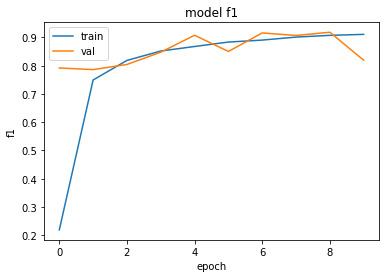

In [0]:
model_picture(model)

### 2 попытка собрать все слои

In [0]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.weights', 
                                                monitor='val_f1', 
                                                verbose=1, 
                                                save_weights_only=True, 
                                                save_best_only=True, 
                                                mode='max', 
                                                save_freq='epoch' 
                                               )

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_f1', 
                                              min_delta=0.01, 
                                              patience=5, 
                                              verbose=1, 
                                              mode='max',
                                              )


In [0]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(sym2id), output_dim=50)(inputs, )

convs = []

conv1 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, activation='relu')(embeddings)
conv2 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, activation='relu')(conv1)
conv3 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, activation='relu')(conv2)
pool1 = tf.keras.layers.AveragePooling1D()(conv3)
drop1 = tf.keras.layers.Dropout(0.2)(pool1)
convs.append(drop1)

conv4 = tf.keras.layers.Conv1D(kernel_size=5, filters=64, strides=1, activation='relu')(embeddings)
conv5 = tf.keras.layers.Conv1D(kernel_size=5, filters=64, strides=1, activation='relu')(conv4)
conv6 = tf.keras.layers.Conv1D(kernel_size=5, filters=64, strides=1, activation='relu')(conv5)
pool2 = tf.keras.layers.AveragePooling1D()(conv6)
drop2 = tf.keras.layers.Dropout(0.2)(pool2)
convs.append(drop2)

conv7 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, activation='relu')(embeddings)
conv8 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, activation='relu')(conv7)
conv9 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, activation='relu')(conv8)
pool3 = tf.keras.layers.AveragePooling1D()(conv9)
drop3 = tf.keras.layers.Dropout(0.2)(pool3)
convs.append(drop3)


concat = tf.keras.layers.Concatenate()(convs)
dense1 = tf.keras.layers.Dense(64, activation='relu')(concat)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense1)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])


In [0]:
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 65)]         0                                            
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 65, 50)       1550        input_15[0][0]                   
__________________________________________________________________________________________________
conv1d_126 (Conv1D)             (None, 61, 32)       8032        embedding_14[0][0]               
__________________________________________________________________________________________________
conv1d_129 (Conv1D)             (None, 61, 64)       16064       embedding_14[0][0]               
___________________________________________________________________________________________

In [0]:
%%time
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=10,
          callbacks=[checkpoint, early_stop])

Epoch 1/10
1240/1241 [============================>.] - ETA: 0s - loss: 0.2209 - f1: 0.0542
Epoch 00001: val_f1 improved from -inf to 0.31546, saving model to model.weights
1241/1241 [==============================] - 29s 24ms/step - loss: 0.2209 - f1: 0.0545 - val_loss: 0.2085 - val_f1: 0.3155
Epoch 2/10
1240/1241 [============================>.] - ETA: 0s - loss: 0.2046 - f1: 0.6501
Epoch 00002: val_f1 improved from 0.31546 to 0.72937, saving model to model.weights
1241/1241 [==============================] - 29s 23ms/step - loss: 0.2046 - f1: 0.6502 - val_loss: 0.2013 - val_f1: 0.7294
Epoch 3/10
1240/1241 [============================>.] - ETA: 0s - loss: 0.2003 - f1: 0.7638
Epoch 00003: val_f1 improved from 0.72937 to 0.82247, saving model to model.weights
1241/1241 [==============================] - 29s 23ms/step - loss: 0.2004 - f1: 0.7638 - val_loss: 0.1993 - val_f1: 0.8225
Epoch 4/10
1240/1241 [============================>.] - ETA: 0s - loss: 0.1984 - f1: 0.8018
Epoch 00004: v

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


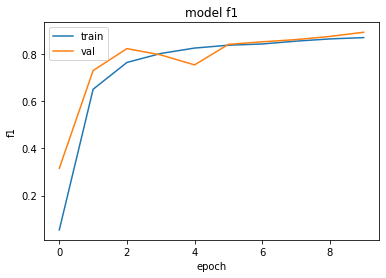

In [0]:
model_picture(model)

In [0]:
# model.save_weights('model.weights')

### 3 попытка собрать все слои

In [0]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.weights', 
                                                monitor='val_f1', 
                                                verbose=1,
                                                save_weights_only=True, 
                                                save_best_only=True, 
                                                mode='max', 
                                                save_freq='epoch' 
                                               )

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_f1', 
                                              min_delta=0.01, 
                                              patience=5,
                                              verbose=1, 
                                              mode='max',
                                              )

In [0]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(sym2id), output_dim=50)(inputs, )

convs = []

conv1 = tf.keras.layers.Conv1D(kernel_size=5, filters=16, padding='same', strides=1, activation='relu')(embeddings)
conv2 = tf.keras.layers.Conv1D(kernel_size=5, filters=16, padding='same', strides=1, activation='relu')(conv1)
conv3 = tf.keras.layers.Conv1D(kernel_size=5, filters=16, padding='same', strides=1, activation='relu')(conv2)
pool1 = tf.keras.layers.AveragePooling1D()(conv3)
drop1 = tf.keras.layers.Dropout(0.2)(pool1)
convs.append(drop1)

conv4 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, padding='same',  strides=1, activation='relu')(embeddings)
conv5 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, padding='same',  strides=1, activation='relu')(conv4)
conv6 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, padding='same', strides=1, activation='relu')(conv5)
pool2 = tf.keras.layers.AveragePooling1D()(conv6)
drop2 = tf.keras.layers.Dropout(0.2)(pool2)
convs.append(drop2)

conv7 = tf.keras.layers.Conv1D(kernel_size=5, filters=16, padding='same', strides=1, activation='relu')(embeddings)
conv8 = tf.keras.layers.Conv1D(kernel_size=5, filters=16, padding='same', strides=1, activation='relu')(conv7)
conv9 = tf.keras.layers.Conv1D(kernel_size=5, filters=16, padding='same', strides=1, activation='relu')(conv8)
pool3 = tf.keras.layers.AveragePooling1D()(conv9)
drop3 = tf.keras.layers.Dropout(0.2)(pool3)
convs.append(drop3)


concat = tf.keras.layers.Concatenate()(convs)
dense1 = tf.keras.layers.Dense(64, activation='relu')(concat)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense1)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1],)


In [0]:
# model.load_weights('model.weights')

In [0]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 65)]         0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 65, 50)       1550        input_14[0][0]                   
__________________________________________________________________________________________________
conv1d_117 (Conv1D)             (None, 65, 16)       4016        embedding_13[0][0]               
__________________________________________________________________________________________________
conv1d_120 (Conv1D)             (None, 65, 32)       8032        embedding_13[0][0]               
___________________________________________________________________________________________

In [0]:
%%time
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=10,
          callbacks=[checkpoint, early_stop])

Epoch 1/10
1239/1241 [============================>.] - ETA: 0s - loss: 0.2266 - f1: 9.8529e-04
Epoch 00001: val_f1 improved from -inf to 0.01524, saving model to model.weights
1241/1241 [==============================] - 24s 19ms/step - loss: 0.2266 - f1: 9.8370e-04 - val_loss: 0.2114 - val_f1: 0.0152
Epoch 2/10
1240/1241 [============================>.] - ETA: 0s - loss: 0.2093 - f1: 0.5331
Epoch 00002: val_f1 improved from 0.01524 to 0.77880, saving model to model.weights
1241/1241 [==============================] - 23s 19ms/step - loss: 0.2093 - f1: 0.5332 - val_loss: 0.2104 - val_f1: 0.7788
Epoch 3/10
1240/1241 [============================>.] - ETA: 0s - loss: 0.2055 - f1: 0.7396
Epoch 00003: val_f1 improved from 0.77880 to 0.82157, saving model to model.weights
1241/1241 [==============================] - 23s 19ms/step - loss: 0.2055 - f1: 0.7398 - val_loss: 0.2061 - val_f1: 0.8216
Epoch 4/10
1240/1241 [============================>.] - ETA: 0s - loss: 0.2035 - f1: 0.7774
Epoch 

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


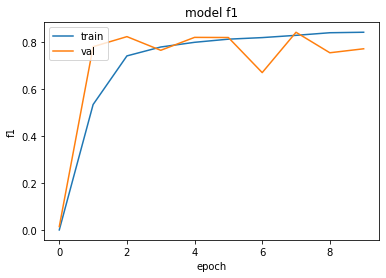

In [0]:
model_picture(model)

## Итоги

1. По какой-то неведомой причине использование каких-либо регуляризаторов заставляло всё падать, график трейна выглядел как упавшая прямая. Поэтому все результаты были достигнуты без использования регуляризаторов.

2. Кажется, модель с заменой знаков препинания и цифр на особые токены в целом меньше переобучается и падает, чем модель без них. При этом у моделей с параметром padding='same' ситуация обратная – лучше выглядит график модели с сохранением почти всех символов.

3. Пробовала сохранять веса лучшей, на мой взгляд, модели и использовать их. Выяснилось, что для использования сохраненных весов необходимо сохранять те же параметры kernel и filters, что и у лучшей модели, а валидация при этом падает. Поэтому все нейронки в дальнейшем обучались отдельно.

4. Изменение параметров Pooling и Dropout также негативно влияло на обучение, графики были очень странными, скачущими